##### Download Training Data and Upload to Azure Data Lake Storage Container

Please copy traning data from 
https://drive.google.com/file/d/1uNsbvMDz7Zz5cyskjNe0HL5LLXlpVvdX/view?usp=share_link to your ADLS container. 

This data is used for model training. 

In this notebook, we will use machine learning and apply NLP techniques to train a machine learning model. The model will use `Reviews` data to predict ratings 

What we are going to do:
- Step 1: Prepare the training data for the machine learning training. 
- Step 2: Train the machine learning model;
- Step 3: Save the model to a Azure storage folder so that you can use it for future prediction. 

#### Set Path to Training Data and Read to Dataframe

In [0]:
# Set file path to the location of the downloaded training data 
file_location = '/mnt/bd-Project/yelp-training-data/*'

reviews = spark.read \
  .parquet(file_location)

#### Print Training Data Schema

In [0]:
reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [0]:
reviews.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|ORL4JE6tz3rJxVqkd...|   0|2015-03-22 19:01:49|    0|RdDRv8WuATj_19ltu...|  4.0|I remember stayin...|     0|FPOLMElOP7Xpqlwgo...|
|RCy4M2ND4YK0uRbod...|   0|2015-04-02 16:52:19|    0|EMJDxWocRuQ-6HsVT...|  4.0|Convenient locati...|     2|vScaSrM91Z43ypSR9...|
|VN2CJfXX6ooJt-Nc3...|   1|2014-11-18 15:31:43|    0|zLD4GdfIjaXZF-cUH...|  5.0|It's huge- you do...|     1|RPrbFB_bcot5TdNvj...|
|GInRkBWvuyJCjFVHY...|   0|2018-03-24 00:18:33|    0|L4DxZ-PGArRpOdEGS...|  1.0|I'm not sure what...|     0|XVCAuOwGZHwtytJal...|
|M4kHDHNzftSUtgpgy...|   0|2017-12-07 19:35:05|    0|OBpNmfGl2ysBpLJ1_...|  5.0|Finally, f

In [0]:
reviews = reviews.select("text", "stars")
reviews.show(5)

+--------------------+-----+
|                text|stars|
+--------------------+-----+
|I remember stayin...|  4.0|
|Convenient locati...|  4.0|
|It's huge- you do...|  5.0|
|I'm not sure what...|  1.0|
|Finally, finally ...|  5.0|
+--------------------+-----+
only showing top 5 rows



In [0]:
# Saving the dataframe to memory for repetitive use
reviews.cache()
reviews.count()

698757


#### Exploratory Data Analysis (EDA) 

In [0]:
%pip install langid==1.1.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--
     ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/1.9 MB 4.1 MB/s eta 0:00:01
     ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/1.9 MB 6.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 0.9/1.9 MB 8.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 1.4/1.9 MB 9.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.9/1.9 MB 11.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941173 sha256=d36a7f7f886144298a7da9f569c3887871b553c7f3b7b09de95523f727b34fd2
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langid
Note: you may need to restart the kernel using %restart_python or dbutil

#### Detect Languages in Text

In [0]:
import langid
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# UDF to detect language
def detect_language(text):
    return langid.classify(text)[0]

detect_language_udf = udf(detect_language, StringType())

# Assuming df is your DataFrame and 'text' is the column with text data
reviews = reviews.withColumn("language", detect_language_udf(reviews.text))

In [0]:
reviews.show(5)

+--------------------+-----+--------+
|                text|stars|language|
+--------------------+-----+--------+
|I remember stayin...|  4.0|      en|
|Convenient locati...|  4.0|      en|
|It's huge- you do...|  5.0|      en|
|I'm not sure what...|  1.0|      en|
|Finally, finally ...|  5.0|      en|
+--------------------+-----+--------+
only showing top 5 rows



In [0]:
# Saving the dataframe to cache for repetitive use

reviews.cache()
reviews.count()

698757

#### Display Top 5 Languages

In [0]:
language_counts = reviews.groupBy("language").count()
language_counts.orderBy("count", ascending=False).show(5)

+--------+------+
|language| count|
+--------+------+
|      en|697986|
|      es|   276|
|      de|    99|
|      fr|    78|
|      it|    72|
+--------+------+
only showing top 5 rows



#### Filter for English Language

In [0]:
reviews = reviews.filter(reviews.language == "en")
reviews = reviews.filter(reviews.language.isNotNull())

In [0]:
reviews.cache()
reviews.count()

697986

In [0]:
%pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/40/ad/c22887189c23cc133ae7cbad48c71312f1a962b960fe7f51fd792808a307/wordcloud-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/548.3 kB ? eta -:--:--
   ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.6/548.3 kB 4.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 542.7/548.3 kB 7.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 7.1 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


#### Generate and Display a Word Cloud from Review Texts

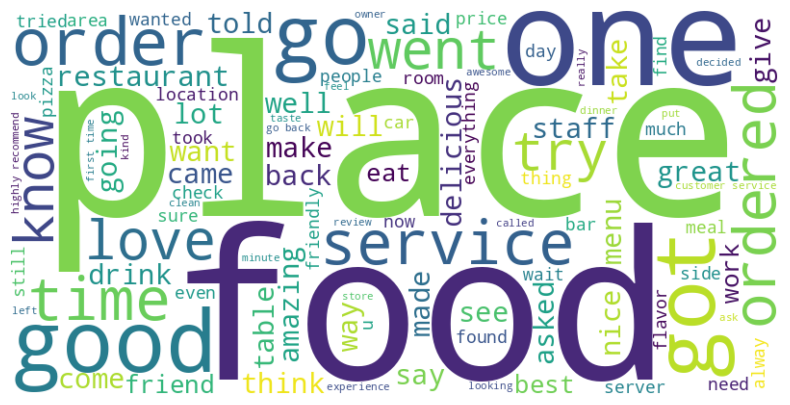

In [0]:
# Display WordCloud using matplotlib

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Collect texts from PySpark DataFrame to the driver 
all_texts = reviews.select("text").rdd.flatMap(lambda x: x).collect()

# Join all text items into a single string
all_text = ' '.join(all_texts)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Text Normalization

##### Text Cleanup

In [0]:
# Performs Lowercase, removes Non-Alphanumeric characters and Extra Spaces from text

from pyspark.sql.functions import lower, regexp_replace, trim

reviews = reviews.withColumn("text", lower(reviews.text)) # Lowercase Conversion
reviews = reviews.withColumn("text", regexp_replace("text", "[^a-zA-Z\\s]", "")) # Remove Punctuation
reviews = reviews.withColumn("text", regexp_replace("text", "\\s+", " ")) # Remove Extra Spaces
reviews = reviews.withColumn("text", trim(reviews.text))


In [0]:
reviews.show(5)

+--------------------+-----+--------+
|                text|stars|language|
+--------------------+-----+--------+
|i remember stayin...|  4.0|      en|
|convenient locati...|  4.0|      en|
|its huge you dont...|  5.0|      en|
|im not sure what ...|  1.0|      en|
|finally finally a...|  5.0|      en|
+--------------------+-----+--------+
only showing top 5 rows



##### Text Tokenization

In [0]:
# Tokenize text for a better text analysis

from pyspark.sql.functions import regexp_replace, trim, split, translate
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tokenized = tokenizer.transform(reviews)

In [0]:
tokenized.show(5)

+--------------------+-----+--------+--------------------+
|                text|stars|language|              tokens|
+--------------------+-----+--------+--------------------+
|i remember stayin...|  4.0|      en|[i, remember, sta...|
|convenient locati...|  4.0|      en|[convenient, loca...|
|its huge you dont...|  5.0|      en|[its, huge, you, ...|
|im not sure what ...|  1.0|      en|[im, not, sure, w...|
|finally finally a...|  5.0|      en|[finally, finally...|
+--------------------+-----+--------+--------------------+
only showing top 5 rows



##### Stop Words Removal

In [0]:
# Remove common words such as "a", "an", "the" etc.

from pyspark.ml.feature import StopWordsRemover

stopword_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")
stopword = stopword_remover.transform(tokenized)

In [0]:
stopword.show(5)

+--------------------+-----+--------+--------------------+--------------------+
|                text|stars|language|              tokens|            filtered|
+--------------------+-----+--------+--------------------+--------------------+
|i remember stayin...|  4.0|      en|[i, remember, sta...|[remember, stayin...|
|convenient locati...|  4.0|      en|[convenient, loca...|[convenient, loca...|
|its huge you dont...|  5.0|      en|[its, huge, you, ...|[huge, dont, real...|
|im not sure what ...|  1.0|      en|[im, not, sure, w...|[im, sure, happen...|
|finally finally a...|  5.0|      en|[finally, finally...|[finally, finally...|
+--------------------+-----+--------+--------------------+--------------------+
only showing top 5 rows



##### Text Vectorization

In [0]:
# converts preprocessed text to numbers in matrix or vector form so that it can be processed mathematically, 
# and important values such as word frequencies, classification, labelling, etc can be derived.

from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(vocabSize=2**16, inputCol="filtered", outputCol='cv')
cv_model = cv.fit(stopword)
text_cv = cv_model.transform(stopword)

In [0]:
text_cv.show(5)

+--------------------+-----+--------+--------------------+--------------------+--------------------+
|                text|stars|language|              tokens|            filtered|                  cv|
+--------------------+-----+--------+--------------------+--------------------+--------------------+
|i remember stayin...|  4.0|      en|[i, remember, sta...|[remember, stayin...|(65536,[2,3,6,15,...|
|convenient locati...|  4.0|      en|[convenient, loca...|[convenient, loca...|(65536,[1,5,7,11,...|
|its huge you dont...|  5.0|      en|[its, huge, you, ...|[huge, dont, real...|(65536,[2,5,6,17,...|
|im not sure what ...|  1.0|      en|[im, not, sure, w...|[im, sure, happen...|(65536,[0,2,3,4,7...|
|finally finally a...|  5.0|      en|[finally, finally...|[finally, finally...|(65536,[0,3,4,29,...|
+--------------------+-----+--------+--------------------+--------------------+--------------------+
only showing top 5 rows



#### Calculate Term Frequency-Inverse Document Frequency (TF-IDF)

In [0]:
# TF-IDF in machine learning is used to evaluate how important a term is within a collection of documents.
# IDF is used with TF to weight terms in text processing by helping to prioritize more meaningful terms 
# over commonly occurring ones. It transformed document-term matrix by removing sparse terms based on 
# a minimum document frequency threshold.

from pyspark.ml.feature import IDF

idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
idf_model = idf.fit(text_cv)
text_idf = idf_model.transform(text_cv)


In [0]:
text_idf.show(5)

+--------------------+-----+--------+--------------------+--------------------+--------------------+--------------------+
|                text|stars|language|              tokens|            filtered|                  cv|            features|
+--------------------+-----+--------+--------------------+--------------------+--------------------+--------------------+
|i remember stayin...|  4.0|      en|[i, remember, sta...|[remember, stayin...|(65536,[2,3,6,15,...|(65536,[2,3,6,15,...|
|convenient locati...|  4.0|      en|[convenient, loca...|[convenient, loca...|(65536,[1,5,7,11,...|(65536,[1,5,7,11,...|
|its huge you dont...|  5.0|      en|[its, huge, you, ...|[huge, dont, real...|(65536,[2,5,6,17,...|(65536,[2,5,6,17,...|
|im not sure what ...|  1.0|      en|[im, not, sure, w...|[im, sure, happen...|(65536,[0,2,3,4,7...|(65536,[0,2,3,4,7...|
|finally finally a...|  5.0|      en|[finally, finally...|[finally, finally...|(65536,[0,3,4,29,...|(65536,[0,3,4,29,...|
+--------------------+--

#### Train and Transform Model

In [0]:
from pyspark.ml.feature import StringIndexer

# transforms values in the "stars" column into consistent 
# numerical label values
label_encoder = StringIndexer(inputCol = "stars", outputCol = "label")

# trains model by learning patterns in the values in the stars column
le_model = label_encoder.fit(text_idf)

# transforms data by generating the label column with the learned patterns 
final = le_model.transform(text_idf)

In [0]:
final.show(5)

+--------------------+-----+--------+--------------------+--------------------+--------------------+--------------------+-----+
|                text|stars|language|              tokens|            filtered|                  cv|            features|label|
+--------------------+-----+--------+--------------------+--------------------+--------------------+--------------------+-----+
|i remember stayin...|  4.0|      en|[i, remember, sta...|[remember, stayin...|(65536,[2,3,6,15,...|(65536,[2,3,6,15,...|  1.0|
|convenient locati...|  4.0|      en|[convenient, loca...|[convenient, loca...|(65536,[1,5,7,11,...|(65536,[1,5,7,11,...|  1.0|
|its huge you dont...|  5.0|      en|[its, huge, you, ...|[huge, dont, real...|(65536,[2,5,6,17,...|(65536,[2,5,6,17,...|  0.0|
|im not sure what ...|  1.0|      en|[im, not, sure, w...|[im, sure, happen...|(65536,[0,2,3,4,7...|(65536,[0,2,3,4,7...|  2.0|
|finally finally a...|  5.0|      en|[finally, finally...|[finally, finally...|(65536,[0,3,4,29,...|(655

#### Split Data to Train and Test Data

In [0]:
train_data, test_data = final.randomSplit([0.8, 0.2], seed=2024)

In [0]:
train_data.cache()
train_data.count()

558142

#### Use RandomForestClassifier Algorithm to Predict

In [0]:
from pyspark.ml.classification import RandomForestClassifier


rf = RandomForestClassifier(numTrees=100, maxDepth=5, seed=42)
rf_model = rf.fit(train_data)  
predictions = rf_model.transform(test_data) 

####  Evaluate Model and Display Accuracy

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
roc_auc = evaluator.evaluate(predictions)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.4626
ROC-AUC: 0.2927


With ROC-AUC of 0.2927, it signifies that the model is not performing well and perhaps the RandomForestClassifier algorithm may not be well suited for the task and might requires significant adjustments or change of algorithm to enhance its classification capability.